# PRMT 2241: What is the average message size for GP2GP messages including / excluding attachments?

In order for the Practice Migration team to estimate the potential transfer speed of a Migration Data Pipeline and provide a basis to the total potential total size of a bulk data set.

Two questions:

What is the average message size for GP2GP messages including attachments?

What is the average message size for GP2GP messages Excluding attachments? <- we won't be able to answer this as we only have attachment size data and not core extract size data

### Requirements

In order to replicate this notebook, perform the following steps:

1. Log into Splunk and run the following query for:
- 01/06/2021 00:00:00:00 to 01/07/2021 00:00:00, export the result as a csv named `6-2021-attachment-metadata.csv` and gzip it. 

```
index="spine2vfmmonitor" logReference=MPS0208
| table _time, attachmentID, conversationID, FromSystem, ToSystem, attachmentType, Compressed, ContentType, LargeAttachment, Length, OriginalBase64, internalID
```

2. Run the following Splunk query for the same time range. Export the results as a csv named `6-2021-gp2gp-messages.csv` and gzip it.

```
index="spine2vfmmonitor" service="gp2gp" logReference="MPS0053d"
| table _time, conversationID, internalID, interactionID
```
 

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
attachment_metadata_file = "s3://prm-gp2gp-data-sandbox-dev/PRMT-2240-tpp-attachment-limit/6-2021-attachment-metadata.csv.gz"
attachments = pd.read_csv(attachment_metadata_file, parse_dates=["_time"], na_values=["Unknown"], dtype={"Length": pd.Int64Dtype()})

In [3]:
gp2gp_messages_file = "s3://prm-gp2gp-data-sandbox-dev/PRMT-2240-tpp-attachment-limit/6-2021-gp2gp-messages.csv.gz"
gp2gp_messages = pd.read_csv(gp2gp_messages_file, parse_dates=["_time"])

## Deduplicate attachment data

In [4]:
ehr_request_completed_messages = gp2gp_messages[gp2gp_messages["interactionID"] == "urn:nhs:names:services:gp2gp/RCMR_IN030000UK06"]

unique_ehr_request_completed_messages = ehr_request_completed_messages.sort_values(by="_time").drop_duplicates(subset=["conversationID"], keep="last")


In [5]:
unique_ehr_request_completed_messages.shape

(242853, 4)

In [6]:
ehr_attachments = pd.merge(attachments, unique_ehr_request_completed_messages[["internalID", "interactionID"]], on="internalID", how="inner")

## Find total average size of attachments for a transfer

In [8]:
attachments_grouped_by_conversation = ehr_attachments.groupby(by="conversationID").agg({"Length": "sum"})
attachments_grouped_by_conversation["Length in Mb"] = attachments_grouped_by_conversation["Length"].fillna(0)/(1024**2)
attachments_grouped_by_conversation["Length in Mb"].describe()

count    129960.000000
mean         21.540058
std          37.884311
min           0.000000
25%           5.306479
50%           9.855163
75%          21.755316
max         928.978714
Name: Length in Mb, dtype: float64

<AxesSubplot:>

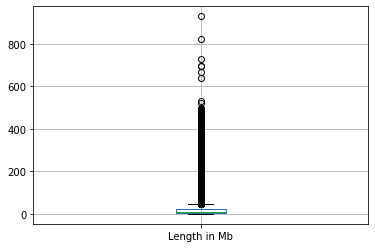

In [11]:
attachments_grouped_by_conversation.boxplot(column="Length in Mb")

array([[<AxesSubplot:title={'center':'Length in Mb'}>]], dtype=object)

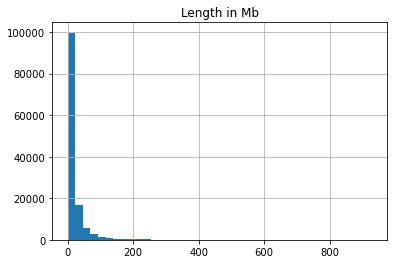

In [10]:
attachments_grouped_by_conversation.hist(column="Length in Mb", bins=40)